# Week 8, Day 4: Walk-Forward Validation

## Learning Objectives
- Understand why cross-validation fails for time series
- Implement walk-forward optimization
- Apply purging and embargo techniques
- Compare rolling vs expanding windows

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
data_path = '../datasets/raw_data/combined_adjusted_close.csv'
prices = pd.read_csv(data_path, index_col='Date', parse_dates=True)

def create_features(price_series):
    """Create ML features with proper lagging."""
    df = pd.DataFrame(index=price_series.index)
    
    # Returns
    for period in [1, 5, 10, 20]:
        df[f'ret_{period}d'] = price_series.pct_change(period).shift(1)
    
    # MA crossovers
    sma_5 = price_series.rolling(5).mean()
    sma_20 = price_series.rolling(20).mean()
    df['sma_cross'] = ((sma_5 / sma_20) - 1).shift(1)
    
    # RSI
    delta = price_series.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - 100 / (1 + gain / loss)).shift(1)
    
    # Volatility
    df['volatility'] = price_series.pct_change().rolling(20).std().shift(1)
    
    # Target
    df['target'] = (price_series.pct_change().shift(-1) > 0).astype(int)
    
    return df.dropna()

# Create dataset
spy_data = create_features(prices['SPY'])
feature_cols = [c for c in spy_data.columns if c != 'target']

X = spy_data[feature_cols]
y = spy_data['target']

print(f"Samples: {len(X)}")
print(f"Features: {len(feature_cols)}")
print(f"Date range: {X.index[0]} to {X.index[-1]}")

Samples: 738
Features: 7
Date range: 2019-03-19 00:00:00 to 2026-01-19 00:00:00


## 1. Why Standard Cross-Validation Fails

Standard K-fold CV can use future data to predict the past → **data leakage**.

In [2]:
from sklearn.model_selection import KFold

# BAD: Standard K-Fold (shows leakage)
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Standard K-fold - WRONG for time series
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

# Time series split - CORRECT
tscv = TimeSeriesSplit(n_splits=5)
scores_ts = cross_val_score(model, X, y, cv=tscv, scoring='accuracy')

print("Cross-Validation Comparison")
print("="*50)
print(f"Standard K-Fold (WRONG): {scores_kfold.mean():.4f} ± {scores_kfold.std():.4f}")
print(f"Time Series Split: {scores_ts.mean():.4f} ± {scores_ts.std():.4f}")
print("\n⚠️  K-Fold accuracy is often inflated due to data leakage!")

Cross-Validation Comparison
Standard K-Fold (WRONG): 0.5393 ± 0.0244
Time Series Split: 0.5480 ± 0.0373

⚠️  K-Fold accuracy is often inflated due to data leakage!


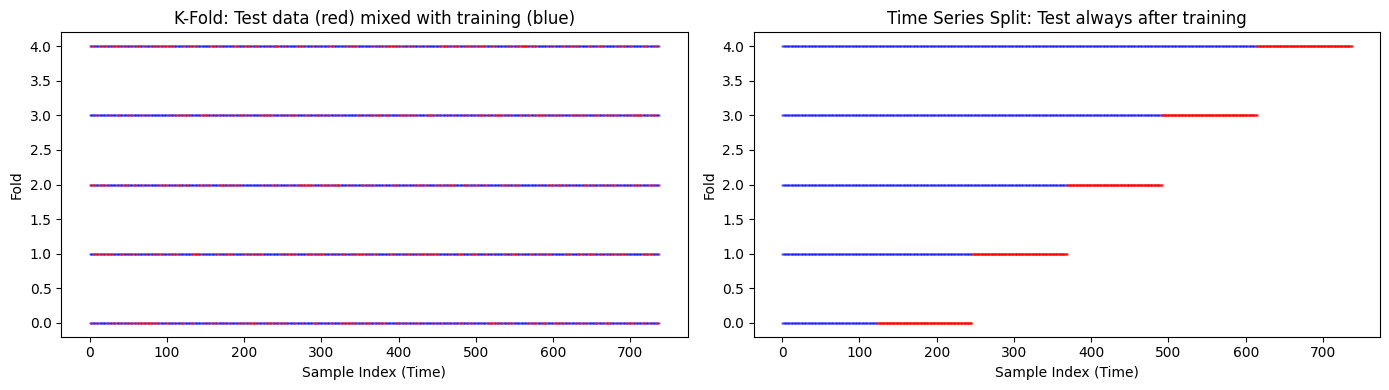

In [3]:
# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# K-Fold splits
ax1 = axes[0]
kfold_splits = list(KFold(n_splits=5, shuffle=True, random_state=42).split(X))
for i, (train_idx, test_idx) in enumerate(kfold_splits):
    ax1.scatter(train_idx, [i]*len(train_idx), c='blue', alpha=0.3, s=1)
    ax1.scatter(test_idx, [i]*len(test_idx), c='red', alpha=0.5, s=1)
ax1.set_xlabel('Sample Index (Time)')
ax1.set_ylabel('Fold')
ax1.set_title('K-Fold: Test data (red) mixed with training (blue)')

# Time Series splits
ax2 = axes[1]
ts_splits = list(TimeSeriesSplit(n_splits=5).split(X))
for i, (train_idx, test_idx) in enumerate(ts_splits):
    ax2.scatter(train_idx, [i]*len(train_idx), c='blue', alpha=0.3, s=1)
    ax2.scatter(test_idx, [i]*len(test_idx), c='red', alpha=0.5, s=1)
ax2.set_xlabel('Sample Index (Time)')
ax2.set_ylabel('Fold')
ax2.set_title('Time Series Split: Test always after training')

plt.tight_layout()
plt.show()

## 2. Walk-Forward Validation

In [4]:
class WalkForwardValidator:
    """Custom walk-forward validation with configurable windows."""
    
    def __init__(self, train_size, test_size, step_size=None, expanding=False):
        self.train_size = train_size
        self.test_size = test_size
        self.step_size = step_size or test_size
        self.expanding = expanding
    
    def split(self, X):
        n = len(X)
        
        if self.expanding:
            # Expanding window: training grows over time
            start = self.train_size
            while start + self.test_size <= n:
                train_idx = list(range(0, start))
                test_idx = list(range(start, min(start + self.test_size, n)))
                yield train_idx, test_idx
                start += self.step_size
        else:
            # Rolling window: fixed training size
            start = self.train_size
            while start + self.test_size <= n:
                train_idx = list(range(start - self.train_size, start))
                test_idx = list(range(start, min(start + self.test_size, n)))
                yield train_idx, test_idx
                start += self.step_size

# Test the validator
rolling_wf = WalkForwardValidator(train_size=500, test_size=100, step_size=100, expanding=False)
expanding_wf = WalkForwardValidator(train_size=500, test_size=100, step_size=100, expanding=True)

print("Rolling Window Walk-Forward:")
for i, (train, test) in enumerate(rolling_wf.split(X)):
    print(f"  Fold {i+1}: Train {train[0]}-{train[-1]}, Test {test[0]}-{test[-1]}")
    if i >= 2:
        print("  ...")
        break

Rolling Window Walk-Forward:
  Fold 1: Train 0-499, Test 500-599
  Fold 2: Train 100-599, Test 600-699


In [5]:
def walk_forward_evaluate(X, y, model_class, model_params, train_size, test_size, expanding=False):
    """Perform walk-forward evaluation and return results."""
    
    wf = WalkForwardValidator(train_size, test_size, expanding=expanding)
    
    results = []
    all_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(wf.split(X)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
        
        # Train model
        model = model_class(**model_params)
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Store results
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        
        results.append({
            'fold': fold + 1,
            'train_end': X.index[train_idx[-1]],
            'test_start': X.index[test_idx[0]],
            'test_end': X.index[test_idx[-1]],
            'accuracy': accuracy,
            'auc': auc
        })
        
        # Store predictions
        for idx, pred, prob in zip(test_idx, y_pred, y_proba):
            all_predictions.append({
                'date': X.index[idx],
                'prediction': pred,
                'probability': prob,
                'actual': y.iloc[idx]
            })
    
    return pd.DataFrame(results), pd.DataFrame(all_predictions)

# Run walk-forward evaluation
model_params = {'n_estimators': 100, 'max_depth': 3, 'random_state': 42}

results_df, predictions_df = walk_forward_evaluate(
    X, y, 
    GradientBoostingClassifier, 
    model_params,
    train_size=500,
    test_size=63,  # ~3 months
    expanding=False
)

print("Walk-Forward Results (Rolling Window)")
print("="*80)
print(results_df.to_string(index=False))
print(f"\nMean Accuracy: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Mean AUC: {results_df['auc'].mean():.4f} ± {results_df['auc'].std():.4f}")

Walk-Forward Results (Rolling Window)
 fold  train_end test_start   test_end  accuracy      auc
    1 2023-11-13 2023-11-14 2024-08-27  0.492063 0.415598
    2 2024-08-27 2024-08-28 2025-04-08  0.539683 0.521830
    3 2025-04-08 2025-04-09 2025-10-10  0.603175 0.624486

Mean Accuracy: 0.5450 ± 0.0557
Mean AUC: 0.5206 ± 0.1044


## 3. Rolling vs Expanding Window

In [6]:
# Compare rolling vs expanding
results_rolling, _ = walk_forward_evaluate(
    X, y, GradientBoostingClassifier, model_params,
    train_size=500, test_size=63, expanding=False
)

results_expanding, _ = walk_forward_evaluate(
    X, y, GradientBoostingClassifier, model_params,
    train_size=500, test_size=63, expanding=True
)

print("Rolling vs Expanding Window Comparison")
print("="*60)
print(f"\n{'Metric':<20} | {'Rolling':>12} | {'Expanding':>12}")
print("-"*50)
print(f"{'Mean Accuracy':<20} | {results_rolling['accuracy'].mean():>11.4f} | {results_expanding['accuracy'].mean():>11.4f}")
print(f"{'Std Accuracy':<20} | {results_rolling['accuracy'].std():>11.4f} | {results_expanding['accuracy'].std():>11.4f}")
print(f"{'Mean AUC':<20} | {results_rolling['auc'].mean():>11.4f} | {results_expanding['auc'].mean():>11.4f}")

Rolling vs Expanding Window Comparison

Metric               |      Rolling |    Expanding
--------------------------------------------------
Mean Accuracy        |      0.5450 |      0.5344
Std Accuracy         |      0.0557 |      0.0399
Mean AUC             |      0.5206 |      0.5054


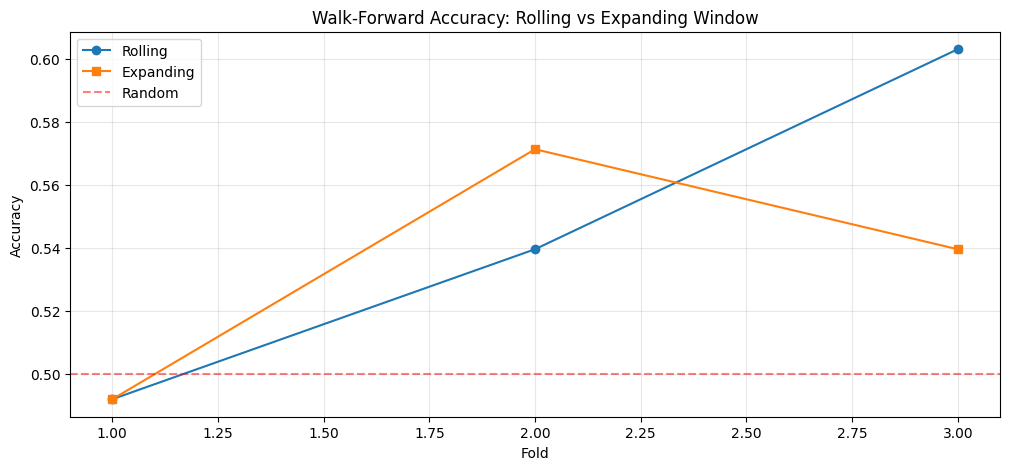

In [7]:
# Plot accuracy over time
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(results_rolling['fold'], results_rolling['accuracy'], 'o-', label='Rolling')
ax.plot(results_expanding['fold'], results_expanding['accuracy'], 's-', label='Expanding')
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random')

ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Walk-Forward Accuracy: Rolling vs Expanding Window')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 4. Purging and Embargo

In [8]:
class PurgedWalkForward:
    """
    Walk-forward validation with purging and embargo.
    - Purge: Remove training samples too close to test period
    - Embargo: Add gap between train and test
    """
    
    def __init__(self, train_size, test_size, purge_size=0, embargo_size=0, step_size=None):
        self.train_size = train_size
        self.test_size = test_size
        self.purge_size = purge_size
        self.embargo_size = embargo_size
        self.step_size = step_size or test_size
    
    def split(self, X):
        n = len(X)
        start = self.train_size
        
        while start + self.test_size <= n:
            # Training window (with purge applied)
            train_end = start - self.purge_size
            train_start = max(0, train_end - self.train_size)
            train_idx = list(range(train_start, train_end))
            
            # Test window (with embargo)
            test_start = start + self.embargo_size
            test_end = min(test_start + self.test_size, n)
            test_idx = list(range(test_start, test_end))
            
            if len(train_idx) > 0 and len(test_idx) > 0:
                yield train_idx, test_idx
            
            start += self.step_size

# Compare with and without purging/embargo
def evaluate_with_purging(X, y, purge_size, embargo_size):
    pwf = PurgedWalkForward(
        train_size=500, 
        test_size=63, 
        purge_size=purge_size,
        embargo_size=embargo_size
    )
    
    accuracies = []
    for train_idx, test_idx in pwf.split(X):
        model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        acc = model.score(X.iloc[test_idx], y.iloc[test_idx])
        accuracies.append(acc)
    
    return np.mean(accuracies), np.std(accuracies)

# Test different purge/embargo settings
settings = [
    (0, 0),
    (5, 0),
    (0, 5),
    (5, 5),
    (10, 5),
]

print("Purging and Embargo Impact")
print("="*60)
print(f"{'Purge':<10} | {'Embargo':<10} | {'Mean Acc':<12} | {'Std Acc':<12}")
print("-"*50)
for purge, embargo in settings:
    mean_acc, std_acc = evaluate_with_purging(X, y, purge, embargo)
    print(f"{purge:<10} | {embargo:<10} | {mean_acc:>11.4f} | {std_acc:>11.4f}")

Purging and Embargo Impact
Purge      | Embargo    | Mean Acc     | Std Acc     
--------------------------------------------------
0          | 0          |      0.5450 |      0.0455
5          | 0          |      0.5238 |      0.0130
0          | 5          |      0.5556 |      0.0686
5          | 5          |      0.5291 |      0.0326
10         | 5          |      0.5503 |      0.0299


## 5. Hyperparameter Tuning with Walk-Forward

In [9]:
def walk_forward_tune(X, y, param_grid, train_size=500, test_size=63):
    """Tune hyperparameters using walk-forward validation."""
    
    results = []
    
    for params in param_grid:
        wf = WalkForwardValidator(train_size, test_size)
        fold_accuracies = []
        
        for train_idx, test_idx in wf.split(X):
            model = GradientBoostingClassifier(**params, random_state=42)
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            acc = model.score(X.iloc[test_idx], y.iloc[test_idx])
            fold_accuracies.append(acc)
        
        results.append({
            **params,
            'mean_accuracy': np.mean(fold_accuracies),
            'std_accuracy': np.std(fold_accuracies)
        })
    
    return pd.DataFrame(results)

# Define parameter grid
param_grid = [
    {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.05},
    {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05},
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05},
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
    {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05},
]

tuning_results = walk_forward_tune(X, y, param_grid)

print("Hyperparameter Tuning Results (Walk-Forward)")
print("="*80)
print(tuning_results.sort_values('mean_accuracy', ascending=False).to_string(index=False))

Hyperparameter Tuning Results (Walk-Forward)
 n_estimators  max_depth  learning_rate  mean_accuracy  std_accuracy
          100          2           0.05       0.592593      0.029930
          100          3           0.05       0.576720      0.019797
           50          2           0.05       0.571429      0.022448
          200          3           0.05       0.550265      0.014965
          100          3           0.10       0.544974      0.045515


## 6. Trading Simulation with Walk-Forward

In [10]:
# Get predictions from walk-forward
_, predictions_df = walk_forward_evaluate(
    X, y, 
    GradientBoostingClassifier, 
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'random_state': 42},
    train_size=500,
    test_size=63,
    expanding=False
)

# Merge with actual returns
predictions_df = predictions_df.set_index('date')
predictions_df['actual_return'] = prices['SPY'].pct_change().shift(-1)
predictions_df = predictions_df.dropna()

# Create signals (only trade when confident)
predictions_df['signal'] = 0
predictions_df.loc[predictions_df['probability'] > 0.55, 'signal'] = 1  # Long
predictions_df.loc[predictions_df['probability'] < 0.45, 'signal'] = -1  # Short

# Calculate strategy returns
predictions_df['strategy_return'] = predictions_df['signal'] * predictions_df['actual_return']

# Performance
cum_strategy = (1 + predictions_df['strategy_return']).cumprod()
cum_buyhold = (1 + predictions_df['actual_return']).cumprod()

# Metrics
strategy_total = cum_strategy.iloc[-1] - 1
buyhold_total = cum_buyhold.iloc[-1] - 1
strategy_sharpe = np.sqrt(252) * predictions_df['strategy_return'].mean() / predictions_df['strategy_return'].std()
buyhold_sharpe = np.sqrt(252) * predictions_df['actual_return'].mean() / predictions_df['actual_return'].std()

print("Walk-Forward Trading Simulation")
print("="*50)
print(f"{'Metric':<20} | {'Strategy':>12} | {'Buy & Hold':>12}")
print("-"*50)
print(f"{'Total Return':<20} | {strategy_total:>11.2%} | {buyhold_total:>11.2%}")
print(f"{'Sharpe Ratio':<20} | {strategy_sharpe:>12.2f} | {buyhold_sharpe:>12.2f}")
print(f"{'Trades':<20} | {(predictions_df['signal'] != 0).sum():>12} | {'N/A':>12}")

Walk-Forward Trading Simulation
Metric               |     Strategy |   Buy & Hold
--------------------------------------------------
Total Return         |       8.06% |      26.21%
Sharpe Ratio         |         0.73 |         1.57
Trades               |          141 |          N/A


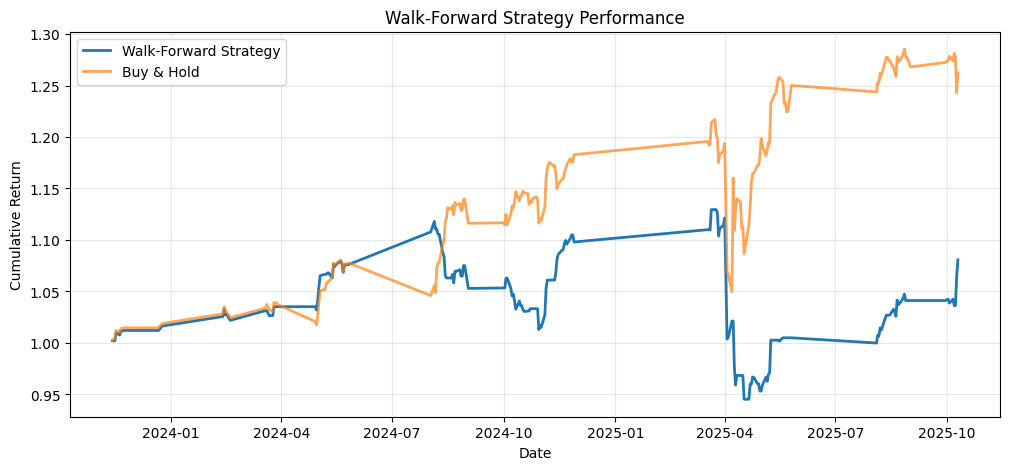

In [11]:
# Plot cumulative returns
plt.figure(figsize=(12, 5))
plt.plot(cum_strategy, label='Walk-Forward Strategy', linewidth=2)
plt.plot(cum_buyhold, label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('Walk-Forward Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Practice Exercises

1. **Window Size Sensitivity**: Test different train/test window sizes.

2. **Model Retraining Frequency**: Compare retraining daily vs weekly vs monthly.

3. **Regime-Dependent Validation**: Use different validation for bull/bear markets.

4. **Combinatorial Purged CV**: Implement more sophisticated purging schemes.

In [12]:
# Exercise: Window size sensitivity
window_sizes = [
    (252, 63),   # 1 year train, 3 months test
    (500, 63),   # 2 years train, 3 months test
    (500, 126),  # 2 years train, 6 months test
    (756, 63),   # 3 years train, 3 months test
]

print("Window Size Sensitivity Analysis")
print("="*60)
print(f"{'Train Size':<12} | {'Test Size':<10} | {'Mean Acc':<12} | {'Std Acc':<12}")
print("-"*50)

for train_size, test_size in window_sizes:
    try:
        results, _ = walk_forward_evaluate(
            X, y, GradientBoostingClassifier, 
            {'n_estimators': 100, 'max_depth': 3, 'random_state': 42},
            train_size=train_size, test_size=test_size
        )
        print(f"{train_size:<12} | {test_size:<10} | {results['accuracy'].mean():>11.4f} | {results['accuracy'].std():>11.4f}")
    except:
        print(f"{train_size:<12} | {test_size:<10} | {'N/A':>11} | {'N/A':>11}")

Window Size Sensitivity Analysis
Train Size   | Test Size  | Mean Acc     | Std Acc     
--------------------------------------------------
252          | 63         |      0.5125 |      0.0665
500          | 63         |      0.5450 |      0.0557
500          | 126        |      0.5000 |         nan
756          | 63         |         N/A |         N/A


## Summary

Today we learned:
- Standard cross-validation leaks future information in time series
- Walk-forward validation properly respects temporal order
- Rolling windows adapt to regime changes, expanding windows use more data
- Purging removes contaminated samples near the test boundary
- Embargo adds extra gap between train and test sets
- Hyperparameter tuning should use walk-forward, not K-fold